In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import matplotlib.dates as mdates
from scipy import integrate
from sklearn.metrics import mean_squared_error

In [2]:
# set a global font and figure size for the plots
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (15,7)

# set max columns for pandas data frames
pd.set_option('display.max_columns', 50)

In [3]:
# Decomment to see available time zones
#import pytz
#pytz.all_timezones

In [4]:
B_0 = 1367 # W/m^2
latitude = 56.158723405318476 # degrees
longitude = 10.215560077919209 # degrees

# 1. Hourly global radiation on a horizontal surface

In [5]:
k_t = 0.7 # clearness index

In [6]:
def eccentricity(day):
    """
    Returns the eccentricity
    
    :param day: day of the year
    :return:    eccentricity
    """
    ecc = 1+0.033*np.cos(360/365*day*np.pi/180)

    return ecc

In [7]:
def solar_time(LT, ET, longitude):
    """
    Returns the true solar time
    
    :param LT:        local time in UTC
    :param ET:        elliptical correction
    :param longitude: longitude in degrees
    :return:          solar time
    """
    st = LT + ET/60 + longitude/15
    
    return st

In [8]:
def ET_correction(day):
    """
    Calculate the elliptical correction
    
    :param day: day of the year
    :return:    ET correction
    """
    B = (day-80)*360/365*np.pi/180
    #B = (day-80)*2/365*np.pi
    ET = 9.87*np.sin(2*B)-7.53*np.cos(B)-1.5*np.sin(B)
    
    return ET

In [9]:
def solar_angle(ST):
    """
    Calculate the solar angle
    
    :param ST: true solar time
    :return:   solar angle in degrees
    """
    return 15*(ST-12)

In [10]:
def declination(day):
    """
    Calculate the solar declination
    
    :param day: day of the year
    :return:    declination in degrees
    """
    result = 23.45*np.sin(360/365*(day+284)*np.pi/180)
    #result = 23.45*np.sin(2*(day-80)/365*np.pi)
    
    return result

In [11]:
def solar_altitude(declination, latitude, solar_angle):
    """
    Calculate the solar altitude/ elevation. If it is negative, return 0
    
    :param declination: declination in degrees
    :param latitude:    latitude in degrees
    :param solar_angle: solar angle in degrees
    :return:            solar altitude in degrees
    """
    delta = declination*np.pi/180
    phi = latitude*np.pi/180
    omega = solar_angle*np.pi/180
    a = np.sin(delta)*np.sin(phi)
    b = np.cos(delta)*np.cos(phi)*np.cos(omega)
    alt = np.arcsin(a+b)*180/np.pi
    
    return np.maximum(0,alt)

In [12]:
def extraterrestrial_radiation(eccentricity, elevation, B_0=1367):
    """
    Calculate the extraterrestrial radiation corrected for the Earth-Sun distance.
    
    :param eccentricity: eccentricity of earth and sun
    :param elevation:    solar elevation in degrees
    :param B_O:          solar constant in W*m^-2
    :return:             extraterrestrial radiation in W*m^-2
    """
    return B_0*eccentricity*np.sin(elevation*np.pi/180)

In [13]:
# Create a data frame with starting and end date in the time zone of Copenhagen with a specific frequency
# Date format: Year-Month-Day
local_time = pd.date_range(start='2018-01-01', end='2018-12-30', freq='H', tz='Europe/Copenhagen')

# Convert the time stamps into UTC
utc_time = local_time.tz_convert('UTC')

# Get the day of the year
day = utc_time.day_of_year

# Create a data frame with the local time, utc time and day of the year as columns
df = pd.DataFrame(local_time, columns=['local time'])
df['utc time'] = utc_time
df[r'day $d_n$'] = day

# Add the corresponding eccentricity and ET correction
df[r'eccentricity $\varepsilon$'] = eccentricity(df['day $d_n$'])
df['correction ET'] = ET_correction(df['day $d_n$'])

# Calculate the local utc time in decimal and add the solar time
lt = df['utc time'].dt.hour + df['utc time'].dt.minute/60 + df['utc time'].dt.second/3600
df['solar time ST'] = solar_time(lt, df['correction ET'], longitude)

# Add the solar angle
df[r'solar angle $\omega$'] = solar_angle(df['solar time ST'])

# Add the declination
df[r'declination $\delta$'] = declination(df[r'day $d_n$'])

# Add the solar altitude
df[r'solar altitude $\gamma_s$'] = solar_altitude(df[r'declination $\delta$'], latitude, df[r'solar angle $\omega$'])

# Add the corrected extraterrestrial radiation
df[r'extraterrestrial $B_0(t)$'] = extraterrestrial_radiation(df[r'eccentricity $\varepsilon$'], df[r'solar altitude $\gamma_s$'])

# Add the global radiation considering the clearness index
df[r'global $G(0,t)$'] = df[r'extraterrestrial $B_0(t)$']*k_t

Plot of the global radiation on a horizontal surface for the first week of February.

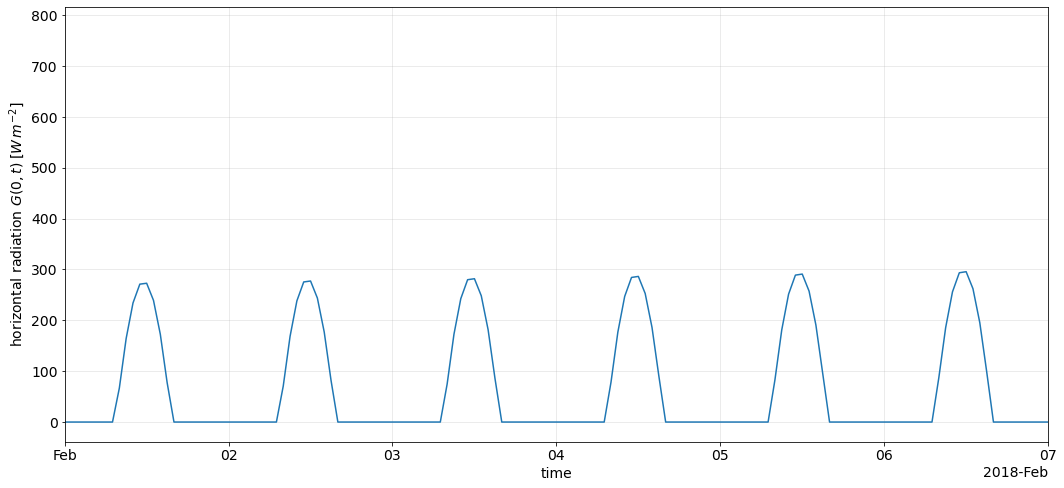

In [14]:
fig, ax = plt.subplots()

ax.plot(df['local time'], df[r'global $G(0,t)$'])
ax.set_xlim([datetime.date(2018, 2, 1), datetime.date(2018, 2, 7)])

ax.set_xlabel('time')
ax.set_ylabel(r'horizontal radiation $G(0,t)\;[W\,m^{-2}]$')
ax.grid(alpha=0.3)

locator = mdates.AutoDateLocator(minticks=6, maxticks=15)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

fig.tight_layout()

#plt.savefig('1_radiation_Feb.pdf')

plt.show()

Plot of the global radiation on a horizontal surface for the first week of June.

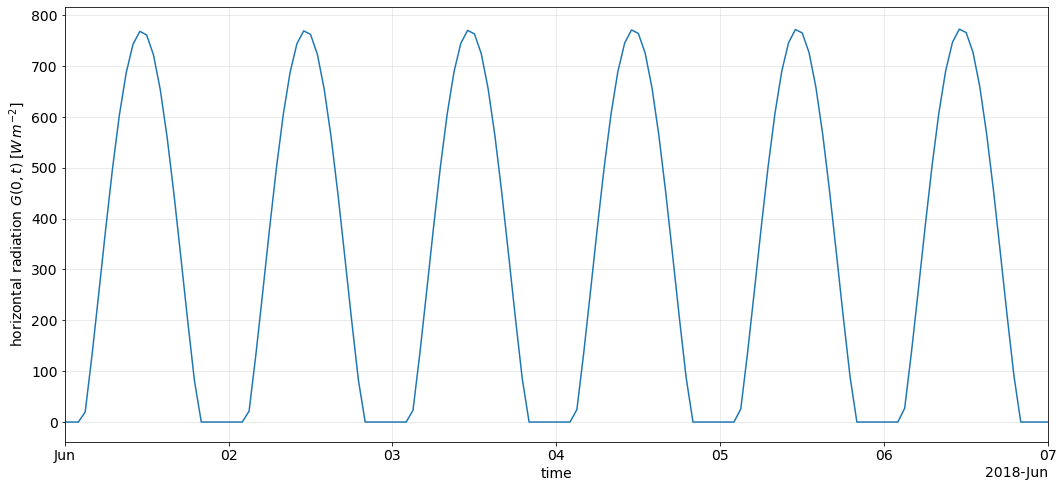

In [15]:
fig, ax = plt.subplots()

ax.plot(df['local time'], df[r'global $G(0,t)$'])
ax.set_xlim([datetime.date(2018, 6, 1), datetime.date(2018, 6, 7)])

ax.set_xlabel('time')
ax.set_ylabel(r'horizontal radiation $G(0,t)\;[W\,m^{-2}]$')
ax.grid(alpha=0.3)

locator = mdates.AutoDateLocator(minticks=6, maxticks=15)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

fig.tight_layout()

#plt.savefig('1_radiation_Jun.pdf')

plt.show()

# 2. Download weather data

In [16]:
# Load the weather data set from Navitas
weather_data = pd.read_csv('weather_data.csv', sep=';')

# Rename the column 'local time'
weather_data.rename(columns={"TimeStamp": "local time"}, inplace=True)

# Drop NaN values
weather_data.dropna(inplace=True)

# Convert the time stamps to datetime objects and assign them to the Copenhagen time zone
weather_data['local time'] =  pd.to_datetime(weather_data['local time'], utc=False)
weather_data['local time'] = weather_data['local time'].dt.tz_localize('Europe/Copenhagen', ambiguous="infer")#.dt.tz_convert('Europe/Copenhagen')

# Convert the local time to UTC time and add it to a column
utc_time = weather_data['local time'].dt.tz_convert('UTC')
weather_data['utc time'] = utc_time

weather_data

,local time,Temp,Cloud,WindVelocity,WindDirection,UV,utc time
0,2018-01-01 01:00:03+01:00,6.6,88.0,2.6,190.0,0.00,2018-01-01 00:00:03+00:00
1,2018-01-01 02:00:03+01:00,7.0,88.0,3.1,200.0,0.00,2018-01-01 01:00:03+00:00
2,2018-01-01 03:00:03+01:00,7.0,80.0,2.6,200.0,0.00,2018-01-01 02:00:03+00:00
3,2018-01-01 03:59:32+01:00,6.4,80.0,2.6,170.0,0.00,2018-01-01 02:59:32+00:00
4,2018-01-01 04:59:32+01:00,6.4,80.0,2.6,200.0,0.00,2018-01-01 03:59:32+00:00
...,...,...,...,...,...,...,...
8285,2018-12-31 12:00:07+01:00,8.1,88.0,3.6,250.0,0.24,2018-12-31 11:00:07+00:00
8286,2018-12-31 14:00:03+01:00,8.0,88.0,4.1,250.0,0.24,2018-12-31 13:00:03+00:00
8287,2018-12-31 15:00:02+01:00,8.0,88.0,3.1,240.0,0.24,2018-12-31 14:00:02+00:00
8288,2018-12-31 17:00:02+01:00,8.0,88.0,6.2,250.0,0.24,2018-12-31 16:00:02+00:00


In [17]:
# Create a data frame consisting of the calculated vlaues 'df' and the weather data frame 'weather_data'
data = df.merge(weather_data, how='outer', on='utc time')

# Sort the dataframe by time
data.sort_values(by='utc time', inplace=True)

# Drop not needed paramters
data.drop(columns=['local time_x','local time_y','WindVelocity','WindDirection','UV'], inplace=True)
#data.drop(columns=['Temp','WindVelocity','WindDirection','UV'], inplace=True)

# Set the UTC time as the index
data.set_index('utc time', inplace=True)

# Interpolate the missing values via time and resample all values hourly
data.interpolate('time', inplace=True)
data = data.resample('H').mean()

# Add local time as column and shift it to first position
data['local time'] = data.index.tz_convert('Europe/Copenhagen')
first_column = data.pop('local time')
data.insert(0, 'local time', first_column)

# Drop NaN values
data.dropna(inplace=True)

# 3. Direct and diffuse radiation on the horizontal surface

In [18]:
# Add the diffuse fraction, which we assume as proportinal to the cloud cover
data['diffuse fraction $k_D$'] = data['Cloud']/100

# Add the global diffuse radiation, which is the global radiation times the diffuse fraction
data[r'diffuse $D(0,t)$'] = data['diffuse fraction $k_D$']*data[r'global $G(0,t)$']

# Add the global direct radiation, which is the global radiation minus the global diffuse radiation
data[r'direct $B(0,t)$'] = data[r'global $G(0,t)$'] - data[r'diffuse $D(0,t)$']

In [19]:
#data

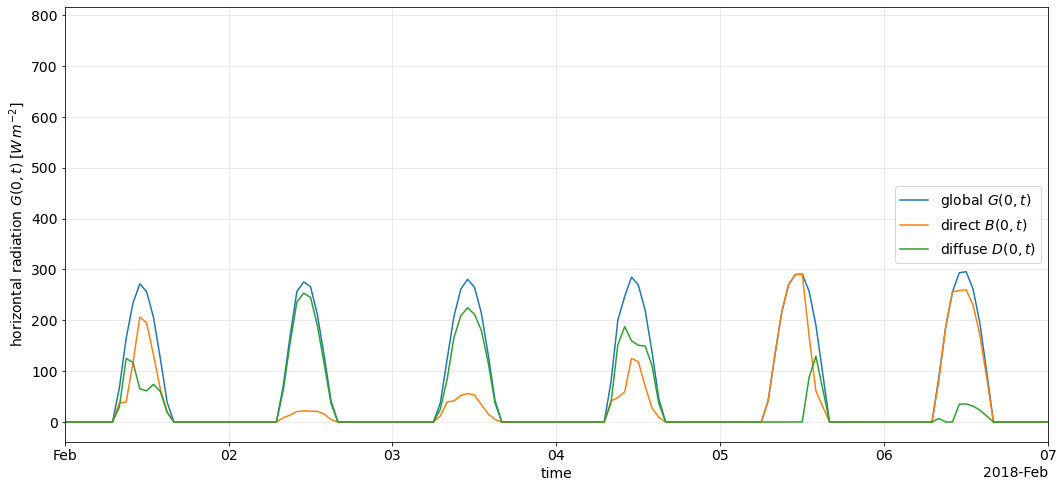

In [20]:
fig, ax = plt.subplots()

ax.plot(data['local time'], data[r'global $G(0,t)$'], label=r'global $G(0,t)$')
ax.plot(data['local time'], data[r'direct $B(0,t)$'], label=r'direct $B(0,t)$')
ax.plot(data['local time'], data[r'diffuse $D(0,t)$'], label=r'diffuse $D(0,t)$')


ax.set_xlim([datetime.date(2018, 2, 1), datetime.date(2018, 2, 7)])

ax.set_xlabel('time')
ax.set_ylabel(r'horizontal radiation $G(0,t)\;[W\,m^{-2}]$')
ax.grid(alpha=0.3)

locator = mdates.AutoDateLocator(minticks=6, maxticks=15)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.legend(loc=5)

fig.tight_layout()

#plt.savefig('1_radiation_Feb.pdf')

plt.show()

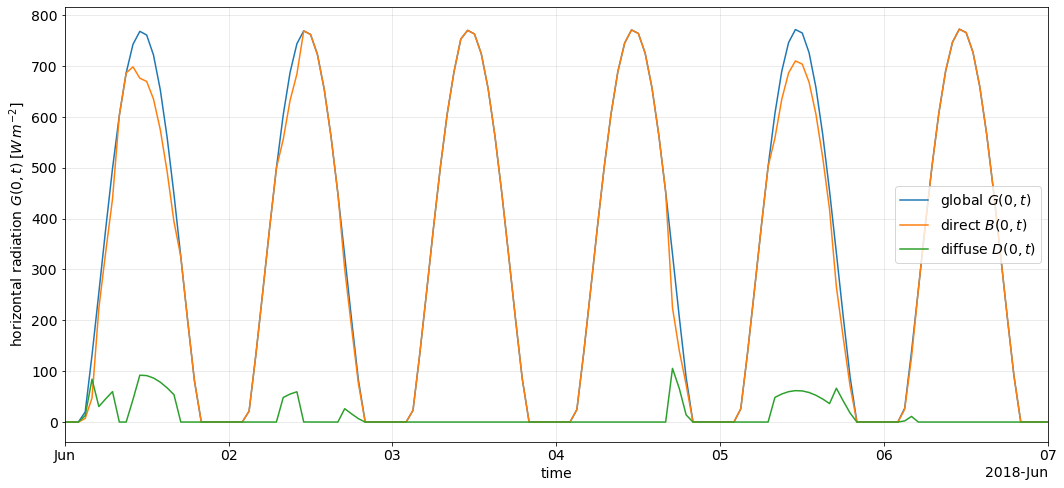

In [21]:
fig, ax = plt.subplots()

ax.plot(data['local time'], data[r'global $G(0,t)$'], label=r'global $G(0,t)$')
ax.plot(data['local time'], data[r'direct $B(0,t)$'], label=r'direct $B(0,t)$')
ax.plot(data['local time'], data[r'diffuse $D(0,t)$'], label=r'diffuse $D(0,t)$')


ax.set_xlim([datetime.date(2018, 6, 1), datetime.date(2018, 6, 7)])

ax.set_xlabel('time')
ax.set_ylabel(r'horizontal radiation $G(0,t)\;[W\,m^{-2}]$')
ax.grid(alpha=0.3)

locator = mdates.AutoDateLocator(minticks=6, maxticks=15)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.legend(loc=5)

fig.tight_layout()

#plt.savefig('1_radiation_Jun.pdf')

plt.show()

# 4. Surface of PV modules

In [22]:
beta = 13 # tilt angle in degrees
alpha = 0 # orientation angle in degrees
rho = 0.05 # reflectivity

# 5. Model the direct, diffuse, and albedo irradiance on the PV modules

In [23]:
def aoi(declination, latitude, tilt_angle, orientation_angle, solar_angle):
    """
    Calculate the angle of incidence. If it is larger than 90°, return 90°
    
    :param declination:       declination in degrees
    :param latitude:          latitude in degrees
    :param tilt_angle:        tilt angle in degrees
    :param orientation_angle: orientation angle in degrees
    :param solar_angle:       solar angle in degrees
    :return:                  angle of incidence in degrees
    """
    delta = declination*np.pi/180
    phi = latitude*np.pi/180
    beta = tilt_angle*np.pi/180
    alpha = orientation_angle*np.pi/180
    omega = solar_angle*np.pi/180
    
    a = np.sin(delta)*np.sin(phi)*np.cos(beta)
    b = np.sin(delta)*np.cos(phi)*np.sin(beta)*np.cos(alpha)
    c = np.cos(delta)*np.cos(phi)*np.cos(beta)*np.cos(omega)
    d = np.cos(delta)*np.sin(phi)*np.sin(beta)*np.cos(alpha)*np.cos(omega)
    e = np.cos(delta)*np.sin(alpha)*np.sin(omega)*np.sin(beta)
    
    result = np.arccos(a-b+c+d+e)*180/np.pi
    
    result = np.where(result > 90, 90, result)
    
    return result

In [24]:
# Add the incident angle
data[r'incident angle $\theta_s$'] = aoi(data[r'declination $\delta$'], latitude, beta, alpha, data[r'solar angle $\omega$'])

## 5.1 Direct radiation $B$

In [25]:
def direct_tilt(direct_radiation, solar_altitude, incident_angle):
    """
    Calculate the direct radiation of a tilted surface.
    
    :param direct_radiation: direct radiation of a plane surface
    :param solar_altitude:   solar altitude in degrees
    :param incident_angle:   incident angle in degrees
    :return:                 direct radiation of a tilted surface
    """
    B = direct_radiation/np.sin(solar_altitude*np.pi/180)
    result = np.where(solar_altitude<=0,0,B)
    
    return result*np.maximum(0,np.cos(incident_angle*np.pi/180))

In [26]:
# Add the direct radiation on the tilted surface
data[r'direct tilted $B$'] = direct_tilt(data[r'direct $B(0,t)$'], data[r'solar altitude $\gamma_s$'], data[r'incident angle $\theta_s$'])

## 5.2 Diffuse radiation $D$

### 5.2.1 Isotropic sky $D_\text{isotropic}$

In [27]:
def diffuse_iso(diffuse_radiation, tilt_angle):
    """
    Calculate the diffuse radiation of a tilted surface assuming sky radiance is isotropic.
    
    :param diffuse_radiation: diffuse radiation of a plane surface
    :param tilt_angle:        tilt angle in degrees
    :return:                  diffuse radiation of a tilted surface
    """
    return diffuse_radiation*((1+np.cos(tilt_angle*np.pi/180))/2)

In [28]:
# Add the diffuse radiation on the tilted surface assuming an isotropic sky
data[r'diffuse tilted $D_\text{isotropic}$'] = diffuse_iso(data[r'diffuse $D(0,t)$'], beta)

### 5.2.2 Circumsolar diffuse radiation $D_\text{circumsolar}$

In [29]:
def diffuse_circumsolar(diffuse_radiation, solar_altitude, incident_angle):
    """
    Calculate the indirect radiation of a tilted surface assuming all diffuse radiation is circumsolar.
    
    :param diffuse_radiation: diffuse radiation of a plane surface
    :param solar_altitude:    solar altitude in degrees
    :param incident_angle:    incident angle in degrees
    :return:                  diffuse radiation of a tilted surface
    """
    D = diffuse_radiation/np.sin(solar_altitude*np.pi/180)
    result = np.where(solar_altitude<=0,0,D)
    
    return result*np.maximum(0,np.cos(incident_angle*np.pi/180))

In [30]:
# Add the diffuse radiation on the tilted surface assuming a circumsolar diffuse radiation
data[r'diffuse tilted $D_\text{circumsolar}$'] = diffuse_circumsolar(data[r'diffuse $D(0,t)$'], data[r'solar altitude $\gamma_s$'], data[r'incident angle $\theta_s$'])

## 5.3 Albedo $R$

In [31]:
def albedo(global_radiation, tilt_angle, reflectivity=0.2):
    """
    Calculate the diffuse radiation of a tilted surface assuming sky radiance is isotropic.
    
    :param diffuse_radiation: diffuse radiation of a plane surface
    :param tilt_angle:        tilt angle in degrees
    :return:                  diffuse radiation of a tilted surface
    """
    return reflectivity*global_radiation*((1+np.cos(tilt_angle*np.pi/180))/2)

In [32]:
# Add the radiation from albedo assuming a reflectivity of 0.05
data[r'albedo $R$'] = albedo(data[r'global $G(0,t)$'], beta, rho)

In [33]:
# Calculate the global radiation on the tilted surface for both different diffuse radiations
data[r'$G_\text{isotropic}$'] = data[r'direct tilted $B$']+data[r'diffuse tilted $D_\text{isotropic}$']+data[r'albedo $R$']
data[r'$G_\text{circumsolar}$'] = data[r'direct tilted $B$']+data[r'diffuse tilted $D_\text{circumsolar}$']+data[r'albedo $R$']

In [34]:
# Print the data frame
data

,local time,day $d_n$,eccentricity $\varepsilon$,correction ET,solar time ST,solar angle $\omega$,declination $\delta$,solar altitude $\gamma_s$,extraterrestrial $B_0(t)$,"global $G(0,t)$",Temp,Cloud,diffuse fraction $k_D$,"diffuse $D(0,t)$","direct $B(0,t)$",incident angle $\theta_s$,direct tilted $B$,diffuse tilted $D_\text{isotropic}$,diffuse tilted $D_\text{circumsolar}$,albedo $R$,$G_\text{isotropic}$,$G_\text{circumsolar}$
utc time,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,2018-01-01 01:00:00+01:00,1.0,1.032995,-4.149710,0.612292,-170.815617,-23.011637,0.0,0.0,0.0,6.600000,88.000000,0.880000,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 01:00:00+00:00,2018-01-01 02:00:00+01:00,1.0,1.032995,-4.149710,1.612292,-155.815617,-23.011637,0.0,0.0,0.0,6.999833,88.000000,0.880000,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 02:00:00+00:00,2018-01-01 03:00:00+01:00,1.0,1.032995,-4.149710,2.942894,-135.856590,-23.011637,0.0,0.0,0.0,6.800000,80.002222,0.800022,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 03:00:00+00:00,2018-01-01 04:00:00+01:00,1.0,1.032995,-4.149710,4.107987,-118.380201,-23.011637,0.0,0.0,0.0,6.400000,80.000000,0.800000,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 04:00:00+00:00,2018-01-01 05:00:00+01:00,1.0,1.032995,-4.149710,4.611876,-110.821867,-23.011637,0.0,0.0,0.0,6.398963,79.958522,0.799585,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 11:00:00+00:00,2018-12-31 12:00:00+01:00,363.0,1.032980,-2.803295,23.634316,174.514736,-23.213917,0.0,0.0,0.0,8.100000,88.000000,0.880000,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-31 13:00:00+00:00,2018-12-31 14:00:00+01:00,363.0,1.032980,-2.803295,23.634316,174.514736,-23.213917,0.0,0.0,0.0,8.000000,88.000000,0.880000,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-31 14:00:00+00:00,2018-12-31 15:00:00+01:00,363.0,1.032980,-2.803295,23.634316,174.514736,-23.213917,0.0,0.0,0.0,8.000000,88.000000,0.880000,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0


Plot of the global radiation on a tilted surface for the first week of February.

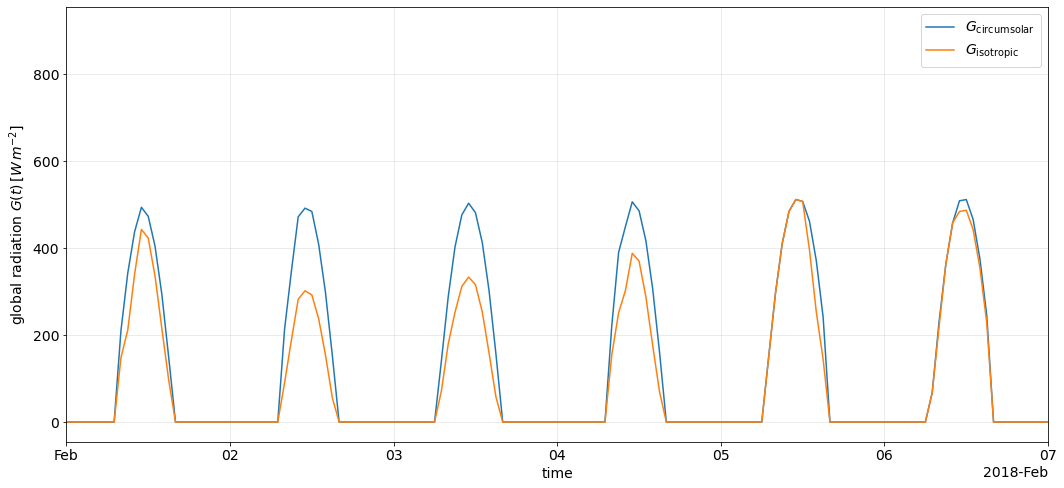

In [35]:
fig, ax = plt.subplots()

ax.plot(data['local time'], data[r'$G_\text{circumsolar}$'], label=r"$G_\mathrm{circumsolar}$")
ax.plot(data['local time'], data[r'$G_\text{isotropic}$'], label=r"$G_\mathrm{isotropic}$")
ax.set_xlim([datetime.date(2018, 2, 1), datetime.date(2018, 2, 7)])

ax.set_xlabel('time')
ax.set_ylabel(r'global radiation $G(t)\,[W\,m^{-2}]$')
ax.grid(alpha=0.3)

locator = mdates.AutoDateLocator(minticks=6, maxticks=15)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

fig.tight_layout()

ax.legend()

#plt.savefig('5_radiation_Feb.pdf')

plt.show()

Plot of the global radiation on a tilted surface for the first week of June.

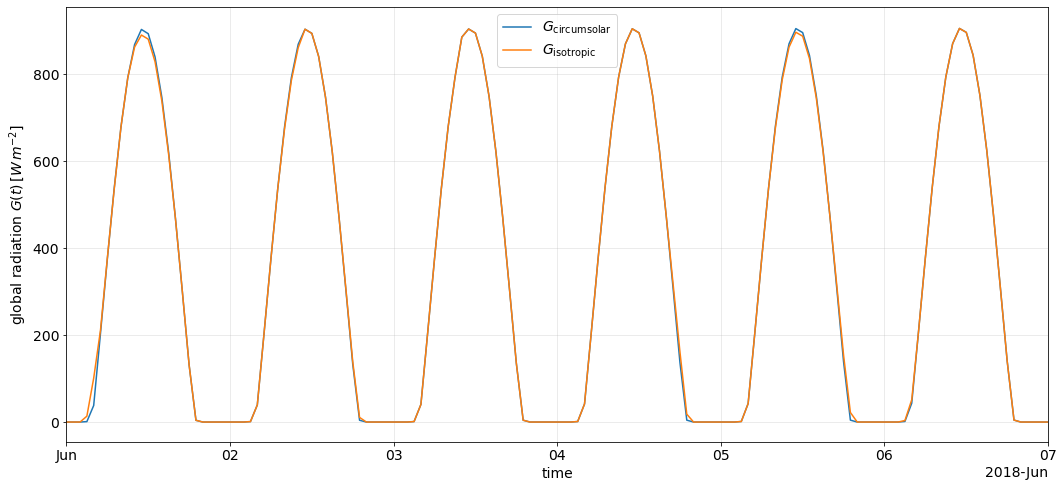

In [36]:
fig, ax = plt.subplots()

ax.plot(data['local time'], data[r'$G_\text{circumsolar}$'], label=r"$G_\mathrm{circumsolar}$")
ax.plot(data['local time'], data[r'$G_\text{isotropic}$'], label=r"$G_\mathrm{isotropic}$")
ax.set_xlim([datetime.date(2018, 6, 1), datetime.date(2018, 6, 7)])

ax.set_xlabel('time')
ax.set_ylabel(r'global radiation $G(t)\,[W\,m^{-2}]$')
ax.grid(alpha=0.3)

locator = mdates.AutoDateLocator(minticks=6, maxticks=15)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

fig.tight_layout()

ax.legend()

#plt.savefig('5_radiation_Jun.pdf')

plt.show()

# 6. Solar cell

In [37]:
# Standars test conditions
G_stc = 1000 # W*m^-2
T_stc = 25 # °C

In [38]:
# Cell properties
area = 0.992*1.64 # m^2
module_efficiency = 0.157
cell_peak_power = 255 # W per module
number_of_cells = 1000
gamma = -0.44*0.01 # °C^-1, tempereture_coefficiant

In [39]:
def cell_temperature(T_air, G, NOCT=45):
    """
    Calculate the temperature of cell
    
    :param T_air: air temperature in °C
    :param G:     incoming radiation in W/m^2
    :param NOCT:  nominal operating cell temperature in °C, standard = 45°C
    :return:      cell temperature in °C
    """
    result = T_air+(NOCT-20)*G/800
    
    return result

In [40]:
def power_per_area(G, T_cell, gamma, mu, T_stc=25):
    """
    Calculate the power per area
    
    :param G:      incoming radiation in W/m^2
    :param T_cell: cell Temperature in °C
    :param gamma:  temperature coefficiant in %/°C
    :param mu:     cell efficiency
    :param T_stc:  temperature under test conditions in °C, standard=25°C
    :return:       power per area in W/m^2
    """
    result = G*(1+gamma*(T_cell-T_stc))*mu
    
    return result

In [41]:
def power_cells(G, T_cell, gamma, cell_peak_power, cells, T_stc=25, G_stc=1000):
    """
    Calculate the power of several cells
    
    :param G:               incoming radiation in W/m^2
    :param T_cell:          cell Temperature in °C
    :param gamma:           temperature coefficiant in 1/°C
    :param cell_peak_power: peak power of each cell in W
    :param cells:           number of cells
    :param T_stc:           temperature under test conditions in °C, standard = 25°C
    :param G_stc:           radiation under test conditions in W/m^2, standard = 1000 W/m^2
    :return:                power of cells in kW
    """
    result = G/G_stc*(1+gamma*(T_cell-T_stc))*cell_peak_power
    
    return cells*result/1000

In [42]:
# Calculate the temperature of the cells assuming isotropic and cicumsolar diffuse radiation
data[r'$T_\text{cell, isotropic}$'] = cell_temperature(data['Temp'], data[r'$G_\text{isotropic}$'])
data[r'$T_\text{cell, circumsolar}$'] = cell_temperature(data['Temp'], data[r'$G_\text{circumsolar}$'])

# Calculate the power of all cells from Navitas assuming isotropic and circumsolar diffuse radiation
data[r'$P_\text{total, isotropic}$'] = power_cells(data[r'$G_\text{isotropic}$'], data[r'$T_\text{cell, isotropic}$'], gamma, cell_peak_power, number_of_cells)
data[r'$P_\text{total, circumsolar}$'] = power_cells(data[r'$G_\text{circumsolar}$'], data[r'$T_\text{cell, circumsolar}$'], gamma, cell_peak_power, number_of_cells)

# Calculate the generated energy over one hour
data[r'$E_\text{hourly, isotropic}$'] = data[r'$P_\text{total, isotropic}$'].rolling(2).apply(integrate.trapz)
data[r'$E_\text{hourly, circumsolar}$'] = data[r'$P_\text{total, circumsolar}$'].rolling(2).apply(integrate.trapz)

# 7. Data from Navitas

In [43]:
# Read the data from the solar cells
power_data = pd.read_excel('CTS Data Aflaesning Strom.xlsx', header=2)

# Drop not used columns
power_data.drop(['Unnamed: 0', 'Uge', 'Dag', 'Total', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33'], axis='columns', inplace=True)

# Rename columns
power_data.rename(columns={"Dato":"local time"}, inplace=True)

# Rename the hourly columns
power_data.rename(columns={"Kl. 01.00": "01:00:00","Kl. 02.00": "02:00:00","Kl. 03.00": "03:00:00","Kl. 04.00": "04:00:00","Kl. 05.00": "05:00:00","Kl. 06.00": "06:00:00",
                          "Kl. 07.00": "07:00:00","Kl. 08.00": "08:00:00","Kl. 09.00": "09:00:00","Kl. 10.00": "10:00:00","Kl. 11.00": "11:00:00","Kl. 12.00": "12:00:00",
                          "Kl. 13.00": "13:00:00","Kl. 14.00": "14:00:00","Kl. 15.00": "15:00:00","Kl. 16.00": "16:00:00","Kl. 17.00": "17:00:00","Kl. 18.00": "18:00:00",
                          "Kl. 19.00": "19:00:00","Kl. 20.00": "20:00:00","Kl. 21.00": "21:00:00","Kl. 22.00": "22:00:00","Kl. 23.00": "23:00:00","Kl. 00.00": "00:00:00",}, inplace=True)

# Convert the time stamps to datetime objects and assign them to the Copenhagen time zone
power_data['local time'] = pd.to_datetime(power_data['local time'], utc=False)
power_data['local time'] = power_data['local time'].dt.tz_localize('Europe/Copenhagen', ambiguous="infer")

# Sort the dataframe by time
power_data.sort_values(by='local time', inplace=True)

# Create index from column Date
power_data = power_data.set_index('local time')

# Remove the daily energy production column and save it in a new data frame
power_data_daily = power_data.pop('Today')
power_data_daily = pd.DataFrame(power_data_daily)

# Shift the mignight column by one
power_data['00:00:00'] = power_data['00:00:00'].shift(1)

# Convert all times to timedelta
power_data.columns = pd.to_timedelta(power_data.columns, errors='raise')

# Reshape - columns to second level of index
power_data = power_data.stack()

# Multindex to index
power_data.index = power_data.index.get_level_values(0) + power_data.index.get_level_values(1)

# Convert the series to a data frame with the column 'energy'
power_data = pd.DataFrame(power_data, columns=[r'$E_\text{hourly, data}$'])

# Sort the dataframe by time
power_data.sort_index(inplace=True)

# Create column from local time index
power_data['local time'] = power_data.index

# Convert the local time to UTC time and add it to a column anmd then assign it as the index
utc_time = power_data['local time'].dt.tz_convert('UTC')
power_data['utc time'] = utc_time
power_data.set_index('utc time', inplace=True)

# Reorder the colmuns
power_data = power_data[[r'$E_\text{hourly, data}$']]

#power_data

In [44]:
# Merge the data frames
df_hour = data.merge(power_data, how='outer', on='utc time')

# Drop missing values
df_hour.dropna(inplace=True)

# Resample the values for daily values
df_day = df_hour.resample('1D').agg({r'$E_\text{hourly, isotropic}$': np.sum, r'$E_\text{hourly, circumsolar}$': np.sum, r'$E_\text{hourly, data}$': np.sum})
df_day.index = df_day.index.date
df_day.rename(columns={r'$E_\text{hourly, isotropic}$':r'$E_\text{daily, isotropic}$', r'$E_\text{hourly, circumsolar}$':r'$E_\text{daily, circumsolar}$', r'$E_\text{hourly, data}$':r'$E_\text{daily, data}$'}, inplace=True)
# Converting the index as date
df_day.index = pd.to_datetime(df_day.index)

# Resample the values for weekly values
df_week = df_hour.resample('1W').agg({r'$E_\text{hourly, isotropic}$': np.sum, r'$E_\text{hourly, circumsolar}$': np.sum, r'$E_\text{hourly, data}$': np.sum})
df_week.index = df_week.index.isocalendar().week
df_week.rename(columns={r'$E_\text{hourly, isotropic}$':r'$E_\text{weekly, isotropic}$', r'$E_\text{hourly, circumsolar}$':r'$E_\text{weekly, circumsolar}$', r'$E_\text{hourly, data}$':r'$E_\text{weekly, data}$'}, inplace=True)
df_week.drop([1], inplace=True)

# Resample the values for monthly values
df_month = df_hour.resample('1M').agg({r'$E_\text{hourly, isotropic}$': np.sum, r'$E_\text{hourly, circumsolar}$': np.sum, r'$E_\text{hourly, data}$': np.sum})
df_month.index = df_month.index.month
df_month.rename(columns={r'$E_\text{hourly, isotropic}$':r'$E_\text{monthly, isotropic}$', r'$E_\text{hourly, circumsolar}$':r'$E_\text{monthly, circumsolar}$', r'$E_\text{hourly, data}$':r'$E_\text{monthly, data}$'}, inplace=True)
# Converting the index as date
#df_month.index = pd.to_datetime(df_month.index)

In [45]:
#df_month.index.to_month

In [46]:
def relative_root_mean_squared_error(true, pred):
    num = np.sum(np.square(true - pred))
    den = np.sum(np.square(pred))
    squared_error = num/den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss

In [47]:
RRMSE_hour_iso = relative_root_mean_squared_error(df_hour[r'$E_\text{hourly, data}$'], df_hour[r'$E_\text{hourly, isotropic}$'])
RRMSE_hour_cir = relative_root_mean_squared_error(df_hour[r'$E_\text{hourly, data}$'], df_hour[r'$E_\text{hourly, circumsolar}$'])

RRMSE_day_iso = relative_root_mean_squared_error(df_day[r'$E_\text{daily, data}$'], df_day[r'$E_\text{daily, isotropic}$'])
RRMSE_day_cir = relative_root_mean_squared_error(df_day[r'$E_\text{daily, data}$'], df_day[r'$E_\text{daily, circumsolar}$'])

RRMSE_week_iso = relative_root_mean_squared_error(df_week[r'$E_\text{weekly, data}$'], df_week[r'$E_\text{weekly, isotropic}$'])
RRMSE_week_cir = relative_root_mean_squared_error(df_week[r'$E_\text{weekly, data}$'], df_week[r'$E_\text{weekly, circumsolar}$'])

RRMSE_month_iso = relative_root_mean_squared_error(df_month[r'$E_\text{monthly, data}$'], df_month[r'$E_\text{monthly, isotropic}$'])
RRMSE_month_cir = relative_root_mean_squared_error(df_month[r'$E_\text{monthly, data}$'], df_month[r'$E_\text{monthly, circumsolar}$'])

errors = dict({'RRMSE_hour_iso':RRMSE_hour_iso, 'RRMSE_hour_cir':RRMSE_hour_cir,
              'RRMSE_day_iso':RRMSE_day_iso, 'RRMSE_day_cir':RRMSE_day_cir,
              'RRMSE_week_iso':RRMSE_week_iso, 'RRMSE_week_cir':RRMSE_week_cir,
              'RRMSE_month_iso':RRMSE_month_iso, 'RRMSE_month_cir':RRMSE_month_cir,})

errors

{'RRMSE_hour_iso': 0.5234677141147038,
 'RRMSE_hour_cir': 0.5754416515471812,
 'RRMSE_day_iso': 0.47149853470690317,
 'RRMSE_day_cir': 0.5235429514816389,
 'RRMSE_week_iso': 0.44876703065047546,
 'RRMSE_week_cir': 0.49858613159437976,
 'RRMSE_month_iso': 0.4436080613252721,
 'RRMSE_month_cir': 0.4935773747890083}

In [48]:
#df_hour
#df_week
#df_week
#df_month.index.month_name

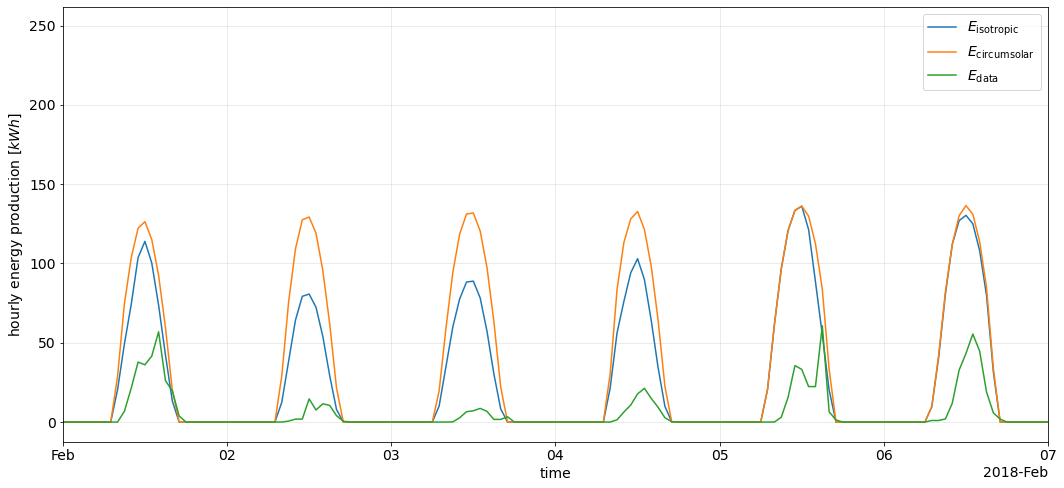

In [49]:
# Hourly energy production
fig, ax = plt.subplots()

ax.plot(df_hour['local time'], df_hour[r'$E_\text{hourly, isotropic}$'],'-', label=r'$E_\mathrm{isotropic}$')
ax.plot(df_hour['local time'], df_hour[r'$E_\text{hourly, circumsolar}$'],'-', label=r'$E_\mathrm{circumsolar}$')
ax.plot(df_hour['local time'], df_hour[r'$E_\text{hourly, data}$'],'-', label=r'$E_\mathrm{data}$')

ax.set_xlim([datetime.date(2018, 2, 1), datetime.date(2018, 2, 7)])

ax.set_xlabel('time')
ax.set_ylabel(r'hourly energy production $[kWh]$')
ax.grid(alpha=0.3)

locator = mdates.AutoDateLocator(minticks=6, maxticks=15)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

fig.tight_layout()

ax.legend()

#plt.savefig('hourly_energy_Feb.pdf')

plt.show()

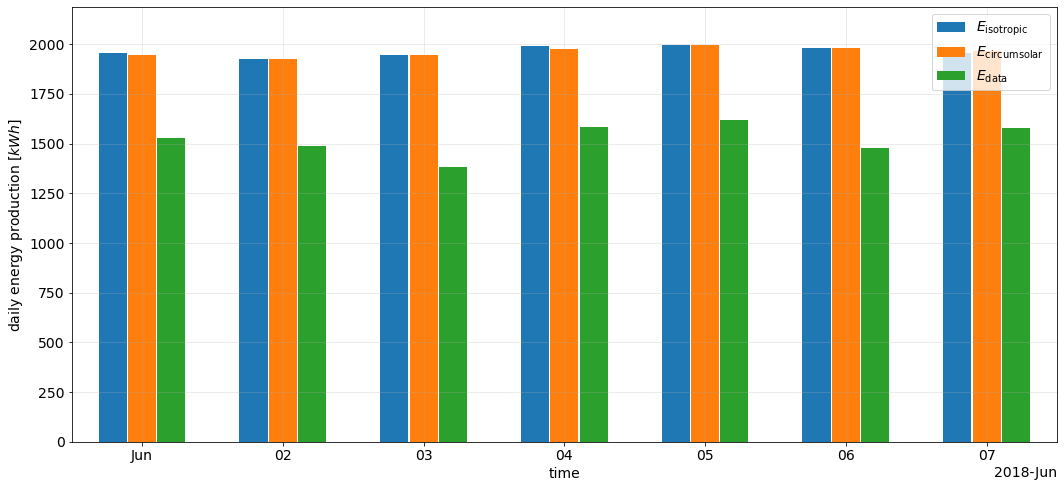

In [50]:
# Daily energy production
fig, ax = plt.subplots()

ax.bar(df_day.index-datetime.timedelta(hours=5), df_day[r'$E_\text{daily, isotropic}$'].values, width=0.2, label=r'$E_\mathrm{isotropic}$')
ax.bar(df_day.index, df_day[r'$E_\text{daily, circumsolar}$'].values, 0.2, label=r'$E_\mathrm{circumsolar}$')
ax.bar(df_day.index+datetime.timedelta(hours=5), df_day[r'$E_\text{daily, data}$'].values, 0.2, label=r'$E_\mathrm{data}$')

ax.set_xlim([datetime.datetime(2018, 5, 31, 12), datetime.datetime(2018, 6, 7, 12)])

ax.set_xlabel('time')
ax.set_ylabel(r'daily energy production $[kWh]$')
ax.grid(alpha=0.3)

locator = mdates.AutoDateLocator(minticks=6, maxticks=15)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

fig.tight_layout()

ax.legend()

#plt.savefig('daily_energy_Jun.pdf')

plt.show()

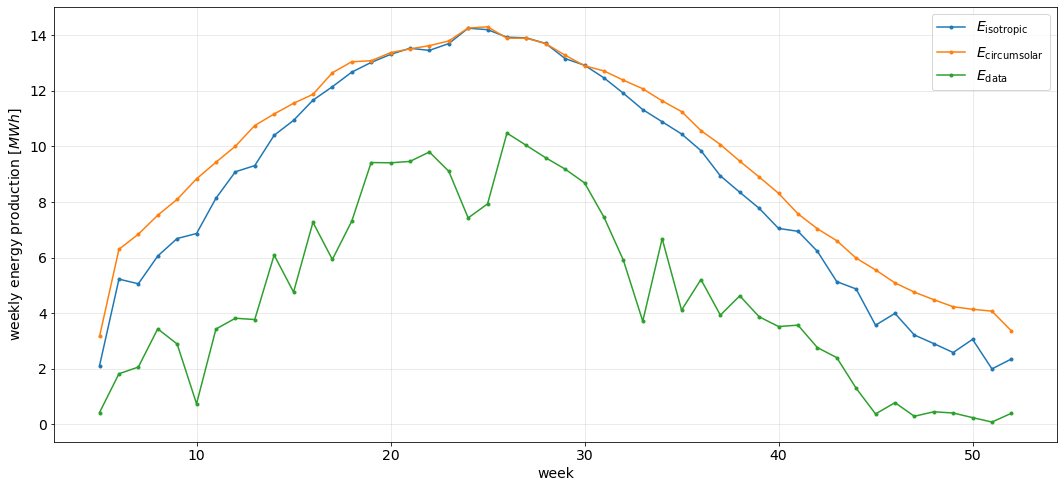

In [51]:
# Weekly energy production
fig, ax = plt.subplots()

#ax.bar(df_week.index-0.2, df_week[r'$E_\text{weekly, isotropic}$'].values/1000, width=0.2, label=r'$E_\mathrm{isotropic}$')
#ax.bar(df_week.index, df_week[r'$E_\text{weekly, circumsolar}$'].values/1000, 0.2, label=r'$E_\mathrm{circumsolar}$')
#ax.bar(df_week.index+0.2, df_week[r'$E_\text{weekly, data}$'].values/1000, 0.2, label=r'$E_\mathrm{data}$')

ax.plot(df_week.index, df_week[r'$E_\text{weekly, isotropic}$']/1000, '.-', label=r'$E_\mathrm{isotropic}$')
ax.plot(df_week.index, df_week[r'$E_\text{weekly, circumsolar}$']/1000, '.-', label=r'$E_\mathrm{circumsolar}$')
ax.plot(df_week.index, df_week[r'$E_\text{weekly, data}$']/1000, '.-', label=r'$E_\mathrm{data}$')

#ax.set_xlim(5, 50)

ax.set_xlabel('week')
ax.set_ylabel(r'weekly energy production $[MWh]$')
ax.grid(alpha=0.3)

#locator = mdates.AutoDateLocator(minticks=6, maxticks=15)
#formatter = mdates.ConciseDateFormatter(locator)
#ax.xaxis.set_major_locator(locator)
#ax.xaxis.set_major_formatter(formatter)

fig.tight_layout()

ax.legend()

#plt.savefig('weekly_energy.pdf')

plt.show()

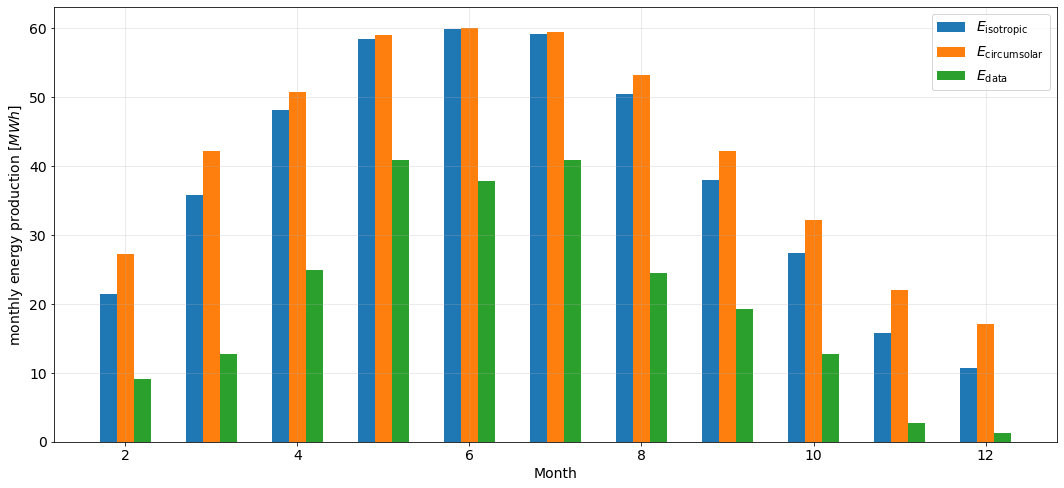

In [52]:
# Monthly energy production
fig, ax = plt.subplots()

ax.bar(df_month.index-0.2, df_month[r'$E_\text{monthly, isotropic}$'].values/1000, width=0.2, label=r'$E_\mathrm{isotropic}$')
ax.bar(df_month.index, df_month[r'$E_\text{monthly, circumsolar}$'].values/1000, 0.2, label=r'$E_\mathrm{circumsolar}$')
ax.bar(df_month.index+0.2, df_month[r'$E_\text{monthly, data}$'].values/1000, 0.2, label=r'$E_\mathrm{data}$')

#ax.plot(df_week.index, df_week[r'$E_\text{weekly, isotropic}$']/1000, '.-', label=r'$E_\mathrm{isotropic}$')
#ax.plot(df_week.index, df_week[r'$E_\text{weekly, circumsolar}$']/1000, '.-', label=r'$E_\mathrm{circumsolar}$')
#ax.plot(df_week.index, df_week[r'$E_\text{weekly, data}$']/1000, '.-', label=r'$E_\mathrm{data}$')

#ax.set_xlim(5, 50)

ax.set_xlabel('Month')
ax.set_ylabel(r'monthly energy production $[MWh]$')
ax.grid(alpha=0.3)

#locator = mdates.AutoDateLocator(minticks=6, maxticks=15)
#formatter = mdates.ConciseDateFormatter(locator)
#ax.xaxis.set_major_locator(locator)
#ax.xaxis.set_major_formatter(formatter)

fig.tight_layout()

ax.legend()

#plt.savefig('monthly_energy.pdf')

plt.show()

In [53]:
df_hour

,local time,day $d_n$,eccentricity $\varepsilon$,correction ET,solar time ST,solar angle $\omega$,declination $\delta$,solar altitude $\gamma_s$,extraterrestrial $B_0(t)$,"global $G(0,t)$",Temp,Cloud,diffuse fraction $k_D$,"diffuse $D(0,t)$","direct $B(0,t)$",incident angle $\theta_s$,direct tilted $B$,diffuse tilted $D_\text{isotropic}$,diffuse tilted $D_\text{circumsolar}$,albedo $R$,$G_\text{isotropic}$,$G_\text{circumsolar}$,"$T_\text{cell, isotropic}$","$T_\text{cell, circumsolar}$","$P_\text{total, isotropic}$","$P_\text{total, circumsolar}$","$E_\text{hourly, isotropic}$","$E_\text{hourly, circumsolar}$","$E_\text{hourly, data}$"
utc time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-02-01 00:00:00+00:00,2018-02-01 01:00:00+01:00,32.0,1.028119,-13.836337,0.949876,-165.751858,-17.516495,0.0,0.0,0.0,2.000000,24.000000,0.240000,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,2.000000,0.0,0.0,0.0,0.0,0.0
2018-02-01 01:00:00+00:00,2018-02-01 02:00:00+01:00,32.0,1.028119,-13.836337,1.950015,-150.749774,-17.516495,0.0,0.0,0.0,2.000000,56.035546,0.560355,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,2.000000,0.0,0.0,0.0,0.0,0.0
2018-02-01 02:00:00+00:00,2018-02-01 03:00:00+01:00,32.0,1.028119,-13.836337,2.949876,-135.751858,-17.516495,0.0,0.0,0.0,2.000000,88.000000,0.880000,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,2.000000,0.0,0.0,0.0,0.0,0.0
2018-02-01 03:00:00+00:00,2018-02-01 04:00:00+01:00,32.0,1.028119,-13.836337,3.949876,-120.751858,-17.516495,0.0,0.0,0.0,2.200222,88.000000,0.880000,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,2.200222,2.200222,0.0,0.0,0.0,0.0,0.0
2018-02-01 04:00:00+00:00,2018-02-01 05:00:00+01:00,32.0,1.028119,-13.836337,4.949876,-105.751858,-17.516495,0.0,0.0,0.0,2.400000,77.988889,0.779889,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,2.400000,2.400000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 11:00:00+00:00,2018-12-31 12:00:00+01:00,363.0,1.032980,-2.803295,23.634316,174.514736,-23.213917,0.0,0.0,0.0,8.100000,88.000000,0.880000,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,8.100000,8.100000,0.0,0.0,0.0,0.0,4.5
2018-12-31 13:00:00+00:00,2018-12-31 14:00:00+01:00,363.0,1.032980,-2.803295,23.634316,174.514736,-23.213917,0.0,0.0,0.0,8.000000,88.000000,0.880000,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,8.000000,8.000000,0.0,0.0,0.0,0.0,12.0
2018-12-31 14:00:00+00:00,2018-12-31 15:00:00+01:00,363.0,1.032980,-2.803295,23.634316,174.514736,-23.213917,0.0,0.0,0.0,8.000000,88.000000,0.880000,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,8.000000,8.000000,0.0,0.0,0.0,0.0,10.8


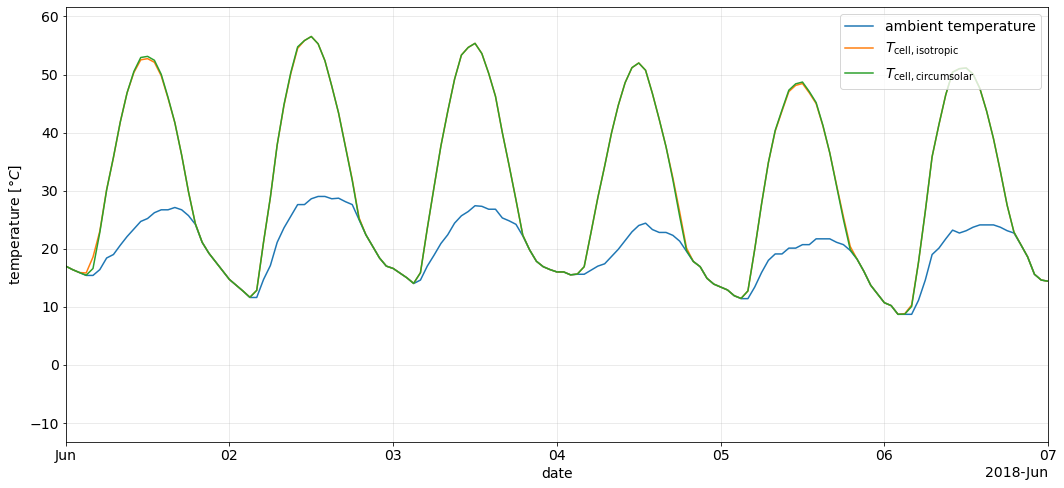

In [73]:
# Temperature
fig, ax = plt.subplots()

#ax2 = ax.twinx()
ax.plot(df_hour['local time'], df_hour['Temp'], '-', label=r'ambient temperature')
ax.plot(df_hour['local time'], df_hour[r'$T_\text{cell, isotropic}$'], '-', label=r'$T_\mathrm{cell, isotropic}$')
ax.plot(df_hour['local time'], df_hour[r'$T_\text{cell, circumsolar}$'], '-', label=r'$T_\mathrm{cell, circumsolar}$')
ax.set_ylabel(r'temperature $[°C]$')

#ax2.plot(df_hour['local time'], df_hour['Cloud'], '-', label=r'cloud')

ax.set_xlim([datetime.date(2018, 6, 1), datetime.date(2018, 6, 7)])
ax.set_xlabel('date')
ax.grid(alpha=0.3)

locator = mdates.AutoDateLocator(minticks=6, maxticks=15)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

fig.tight_layout()

ax.legend(loc=1)

plt.savefig('temperatures_jun.pdf')

plt.show()